In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Performance monitoring
import time
import psutil
from functools import wraps

# Animation and visualization imports
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Parallel processing optimization
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

# Network analysis
from networkx.algorithms.flow import shortest_augmenting_path

# Set random seed for reproducibility
np.random.seed(42)

# Performance monitoring decorator
def monitor_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        result = func(*args, **kwargs)
        
        end_time = time.time()
        end_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        print(f"Execution time for {func.__name__}: {end_time - start_time:.2f}s | Memory change: {end_memory - start_memory:+.1f}MB")
        return result
    return wrapper

print("Libraries imported successfully!")
print(f"Available CPU cores: {mp.cpu_count()}")
print(f"Available memory: {psutil.virtual_memory().available / 1024**3:.1f} GB")




Libraries imported successfully!
Available CPU cores: 20
Available memory: 7.7 GB


In [12]:
# Load data from CSV file
print("Loading data from dataset.csv...")
try:
    edges_df = pd.read_csv('/home/algorithm/project/EvacuationPJ/dataset.csv')
    print(f"Successfully loaded {len(edges_df)} data  from dataset.csv")
    print(f"Columns: {list(edges_df.columns)}")
    print(f"Sample data:")
    print(edges_df.head())
except Exception as e:
    print(f"Error loading dataset.csv: {e}")
    edges_df = None

Loading data from dataset.csv...
Successfully loaded 533 data  from dataset.csv
Columns: ['u', 'v', 'key', 'osmid', 'highway', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'lanes', 'maxspeed', 'bridge', 'tunnel', 'width', 'access']
Sample data:
          u           v  key      osmid  highway   name  oneway    ref  \
0  31253600  7092267898    0   23705307  primary  新大橋通り    True   50.0   
1  31253600    31253943    0   25824161  primary  新大橋通り    True   50.0   
2  31253776  9510994556    0  879780891  primary   海岸通り    True  316.0   
3  31253943  7092267898    0  894991906  primary   海岸通り    True  316.0   
4  31253982    31253943    0  894991907  primary   海岸通り    True  316.0   

   reversed     length                                           geometry  \
0     False  41.987798  LINESTRING (139.7635869 35.663609, 139.7634711...   
1     False  28.281910  LINESTRING (139.7635869 35.663609, 139.7634651...   
2     False  28.036136  LINESTRING (139.7634712 35.6646214, 139.7

In [13]:
# Process the loaded CSV data to create nodes and edges
if edges_df is not None:
    # Create nodes from unique source and target nodes
    unique_nodes = pd.unique(edges_df[['u', 'v']].values.ravel('K'))
    
    # Create nodes DataFrame with basic geometry (simplified coordinates)
    nodes_data = []
    for i, node_id in enumerate(unique_nodes):
        # For node ID
        nodes_data.append({
            'node_id': node_id,
        })
    
    nodes = pd.DataFrame(nodes_data).set_index('node_id')
    
    # Add random population to each node
    np.random.seed(42)  # For reproducible results
    num_nodes = len(nodes)
    
    # Generate random population for each node
    # Using different distribution strategies for variety
    residential_nodes = int(num_nodes * 0.6)  # 60% residential areas
    commercial_nodes = int(num_nodes * 0.25)  # 25% commercial areas
    industrial_nodes = num_nodes - residential_nodes - commercial_nodes  # 15% industrial/other
    
    populations = []
    
    # Residential areas: higher population (50-500 people per node)
    populations.extend(np.random.randint(50, 501, residential_nodes))
    
    # Commercial areas: moderate population (10-200 people per node)
    populations.extend(np.random.randint(10, 201, commercial_nodes))
    
    # Industrial/other areas: lower population (0-100 people per node)
    populations.extend(np.random.randint(0, 101, industrial_nodes))
    
    # Shuffle to randomize distribution across nodes
    np.random.shuffle(populations)
    
    # Assign population to nodes
    nodes['population'] = populations
    
    # Add node types for reference
    node_types = ['residential'] * residential_nodes + ['commercial'] * commercial_nodes + ['industrial'] * industrial_nodes
    np.random.shuffle(node_types)
    nodes['node_type'] = node_types
    
    # Calculate total population
    total_population = nodes['population'].sum()
    
    print(f"Population Distribution:")
    print(f"Total population across all nodes: {total_population:,}")
    print(f"Average population per node: {nodes['population'].mean():.1f}")
    print(f"Population range: {nodes['population'].min()} - {nodes['population'].max()}")
    print(f"\nNode type distribution:")
    print(nodes['node_type'].value_counts())
    print(f"\nPopulation by node type:")
    print(nodes.groupby('node_type')['population'].agg(['count', 'sum', 'mean']).round(1))
    
    # Process edges data
    edges = edges_df.copy()
    
    # Calculate basic edge properties
    edges['travel_time'] = edges['length'] / 50  # Assume 50 units per time unit
    edges['capacity'] = edges['length'] * 0.1  # Simple capacity based on length
    
    print(f"Network Statistics:")
    print(f"Number of nodes: {len(nodes)}")
    print(f"Number of edges: {len(edges)}")
    print(f"\nNodes columns: {list(nodes.columns)}")
    print(f"\nEdges columns: {list(edges.columns)}")
    
    # Display sample of processed data
    print(f"\nSample nodes:")
    print(nodes.head())
    print(f"\nSample edges:")
    print(edges[['u', 'v', 'length', 'travel_time', 'capacity']].head())
else:
    print("Cannot process data - edges_df is None")

# Evacuation simulation parameters
class EvacuationParameters:
    def __init__(self, nodes_df=None):
        # Update population based on loaded data

        self.total_population = nodes_df['population'].sum()
        self.total_households = int(self.total_population * 0.4)  # Approximate
        
        # Evacuation parameters
        self.time_step = 1  # minutes
        self.walking_speed = 5  # km/h
        self.driving_speed = 30  # km/h
        # Capacity parameters
        self.road_capacity_per_meter = 1  # persons per meter of road width
        self.default_road_width = 5
        
params = EvacuationParameters(nodes)
print(f"Evacuation Parameters:")
print(f"Total Population: {params.total_population:,}")
print(f"Time Steps: {params.time_step} minutes")


Population Distribution:
Total population across all nodes: 56,986
Average population per node: 202.8
Population range: 0 - 498

Node type distribution:
node_type
residential    168
commercial      70
industrial      43
Name: count, dtype: int64

Population by node type:
             count    sum   mean
node_type                       
commercial      70  12608  180.1
industrial      43   8183  190.3
residential    168  36195  215.4
Network Statistics:
Number of nodes: 281
Number of edges: 533

Nodes columns: ['population', 'node_type']

Edges columns: ['u', 'v', 'key', 'osmid', 'highway', 'name', 'oneway', 'ref', 'reversed', 'length', 'geometry', 'lanes', 'maxspeed', 'bridge', 'tunnel', 'width', 'access', 'travel_time', 'capacity']

Sample nodes:
          population    node_type
node_id                          
31253600         429  residential
31253776         130  residential
31253943         100   commercial
31253982         267  residential
31254273         100  residential

Sam

In [14]:
import re

# Function to parse LINESTRING geometry
def parse_linestring(linestring_str):
    """Parse LINESTRING format to extract coordinates"""
    if pd.isna(linestring_str) or linestring_str == '':
        return None
    
    # Extract coordinates from LINESTRING format
    pattern = r'LINESTRING \(([^)]+)\)'
    match = re.search(pattern, linestring_str)
    if not match:
        return None
    
    coords_str = match.group(1)
    coords = []
    for coord_pair in coords_str.split(', '):
        lon, lat = map(float, coord_pair.split())
        coords.append([lat, lon])  # Note: folium expects [lat, lon]
    return coords

# Function to get node coordinates from edges
def extract_node_coordinates(edges_df):
    """Extract node coordinates from edge geometry data"""
    node_coords = {}
    
    for idx, row in edges_df.iterrows():
        coords = parse_linestring(row['geometry'])
        if coords:
            u_node = row['u']
            v_node = row['v']
            
            # Store first coordinate for u node if not already stored
            if u_node not in node_coords:
                node_coords[u_node] = coords[0]  # [lat, lon]
            
            # Store last coordinate for v node if not already stored
            if v_node not in node_coords:
                node_coords[v_node] = coords[-1]  # [lat, lon]
    
    return node_coords

# Extract node coordinates from the dataset
if edges_df is not None:
    print("Processing geometric data for mapping...")
    
    # Extract node coordinates
    node_coordinates = extract_node_coordinates(edges_df)
    print(f"Extracted coordinates for {len(node_coordinates)} nodes")
    
    # Add coordinates to nodes DataFrame
    if 'nodes' in locals() and nodes is not None:
        nodes['lat'] = nodes.index.map(lambda x: node_coordinates.get(x, [None, None])[0])
        nodes['lon'] = nodes.index.map(lambda x: node_coordinates.get(x, [None, None])[1])
        
        # Remove nodes without coordinates
        nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
        print(f"Nodes with valid coordinates: {len(nodes_with_coords)}")
    
    # Process edge geometries
    edges_df['coordinates'] = edges_df['geometry'].apply(parse_linestring)
    edges_with_geom = edges_df.dropna(subset=['coordinates'])
    print(f"Edges with valid geometry: {len(edges_with_geom)}")
    
    # Calculate bounding box for the map
    all_coords = []
    for coords_list in edges_with_geom['coordinates']:
        if coords_list:
            all_coords.extend(coords_list)
    
    if all_coords:
        lats = [coord[0] for coord in all_coords]
        lons = [coord[1] for coord in all_coords]
        
        center_lat = (min(lats) + max(lats)) / 2
        center_lon = (min(lons) + max(lons)) / 2
        
        print(f"Map bounds:")
        print(f"  Latitude: {min(lats):.6f} to {max(lats):.6f}")
        print(f"  Longitude: {min(lons):.6f} to {max(lons):.6f}")
        print(f"  Center: ({center_lat:.6f}, {center_lon:.6f})")
        
        # Store for map creation
        map_bounds = {
            'center': [center_lat, center_lon],
            'min_lat': min(lats),
            'max_lat': max(lats),
            'min_lon': min(lons),
            'max_lon': max(lons)
        }
    else:
        print("No valid coordinates found!")
else:
    print("No edge data available for processing")

Processing geometric data for mapping...
Extracted coordinates for 281 nodes
Nodes with valid coordinates: 281
Edges with valid geometry: 533
Map bounds:
  Latitude: 35.663554 to 35.675597
  Longitude: 139.758785 to 139.772396
  Center: (35.669575, 139.765590)


Creating static network visualization...


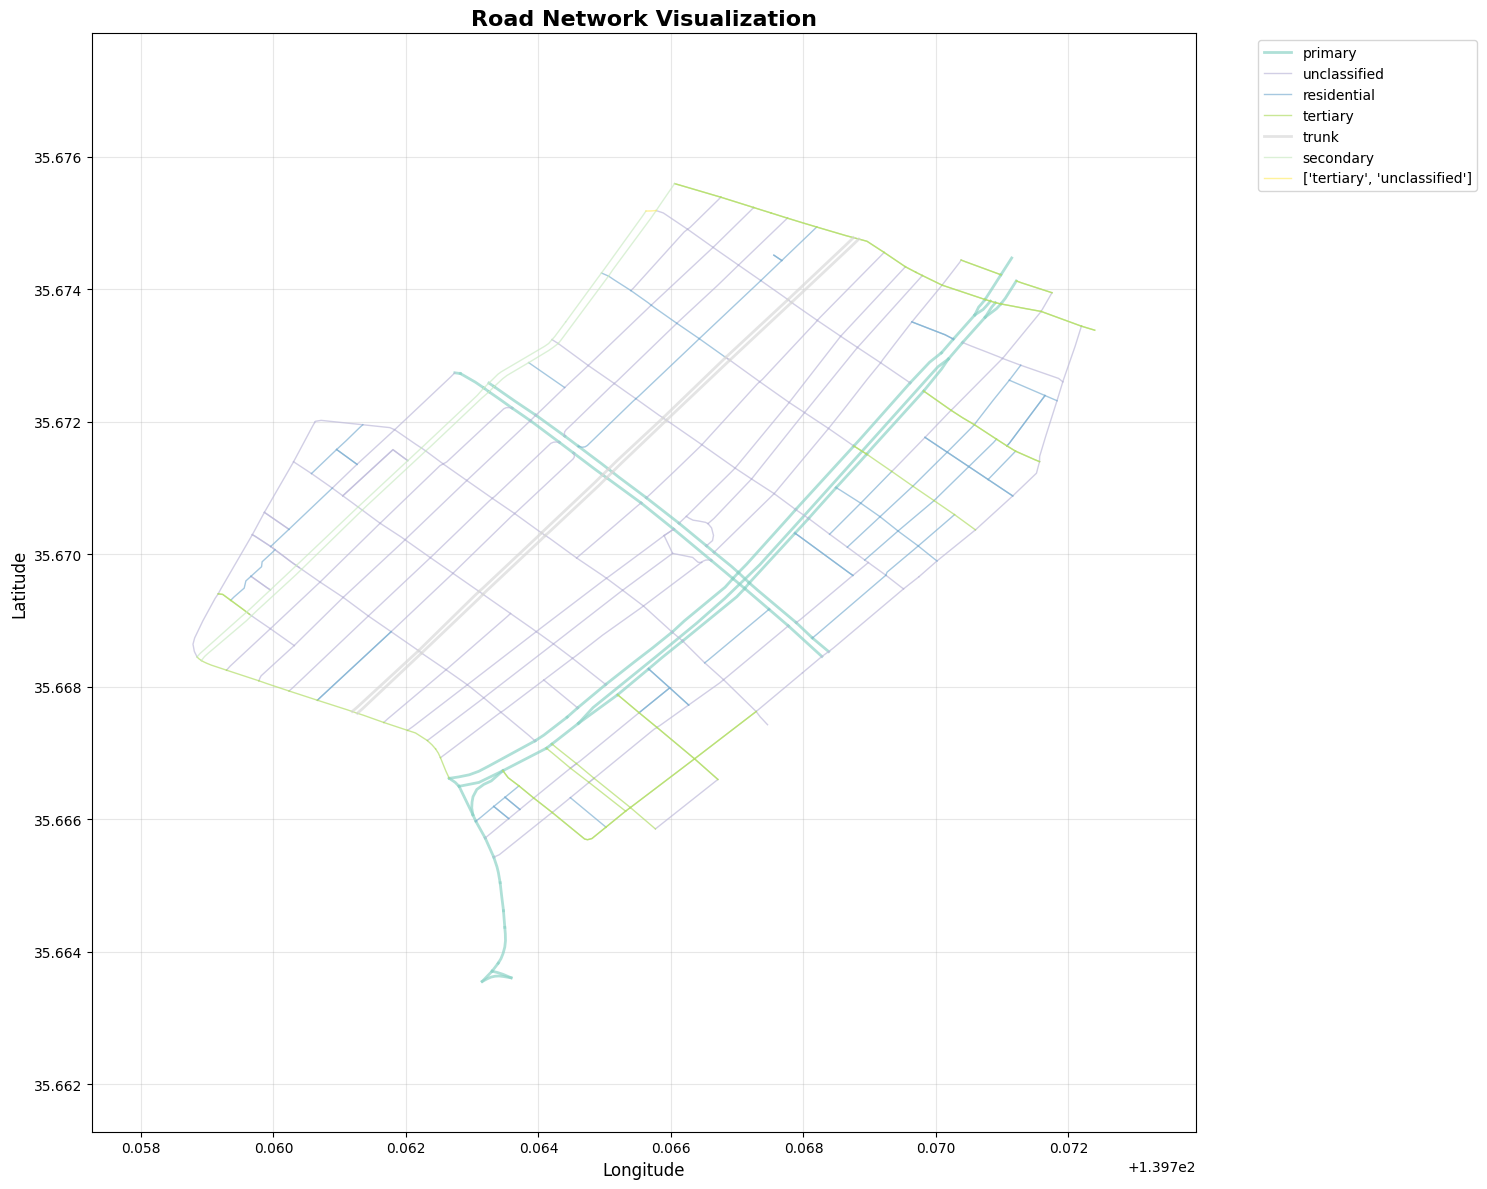

Static visualization created and saved


In [15]:
# Create static visualization with matplotlib
if 'map_bounds' in locals() and edges_with_geom is not None:
    print("Creating static network visualization...")
    
    plt.figure(figsize=(15, 12))
    
    # Create color map for different road types
    unique_highways = edges_with_geom['highway'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_highways)))
    highway_colors = dict(zip(unique_highways, colors))
    
    # Plot roads
    for highway_type in unique_highways:
        highway_edges = edges_with_geom[edges_with_geom['highway'] == highway_type]
        
        for idx, row in highway_edges.iterrows():
            coords = row['coordinates']
            if coords and len(coords) > 1:
                lats = [coord[0] for coord in coords]
                lons = [coord[1] for coord in coords]
                
                plt.plot(lons, lats, 
                        color=highway_colors[highway_type], 
                        linewidth=2 if highway_type in ['primary', 'trunk', 'motorway'] else 1,
                        alpha=0.7,
                        label=highway_type if idx == highway_edges.index[0] else "")
    
    # Customize plot
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title('Road Network Visualization', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Equal aspect ratio for geographic accuracy
    plt.axis('equal')
    
    # Tight layout
    plt.tight_layout()
    
    # Save the plot

    plt.show()
    
    print("Static visualization created and saved")
else:
    print("Cannot create static visualization - missing data")

In [16]:
# Create NetworkX graph for network analysis
if edges_df is not None and 'node_coordinates' in locals():
    print("Creating NetworkX graph for network analysis...")
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add nodes with coordinates
    for node_id, coords in node_coordinates.items():
        if coords[0] is not None and coords[1] is not None:
            G.add_node(node_id, lat=coords[0], lon=coords[1])
    
    # Add edges with attributes
    for idx, row in edges_df.iterrows():
        if row['u'] in G.nodes and row['v'] in G.nodes:
            G.add_edge(row['u'], row['v'], 
                      length=row['length'],
                      highway=row.get('highway', 'unknown'),
                      name=row.get('name', ''),
                      travel_time=row.get('travel_time', row['length']/50))
    
    print(f"NetworkX Graph Statistics:")
    print(f"  Nodes: {G.number_of_nodes():,}")
    print(f"  Edges: {G.number_of_edges():,}")
    print(f"  Is connected: {nx.is_weakly_connected(G)}")
    print(f"  Number of weakly connected components: {nx.number_weakly_connected_components(G)}")
    
    # Calculate basic network metrics
    if G.number_of_nodes() > 0:
        try:
            # Degree statistics
            degrees = dict(G.degree())
            avg_degree = sum(degrees.values()) / len(degrees)
            max_degree = max(degrees.values())
            
            print(f"  Average degree: {avg_degree:.2f}")
            print(f"  Maximum degree: {max_degree}")
            
            # Find nodes with highest degrees (important intersections)
            high_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"  Top 5 nodes by degree (major intersections):")
            for node, degree in high_degree_nodes:
                coords = node_coordinates.get(node, [None, None])
                print(f"    Node ID: {node} | Degree: {degree} | Coords: {coords}")
            
            # Show shelter nodes information
            print(f"  Shelter nodes information:")
            for shelter in [31253600, 31253776]:  # SINK_NODE_1, SINK_NODE_2
                if shelter in G.nodes:
                    shelter_degree = degrees.get(shelter, 0)
                    shelter_coords = node_coordinates.get(shelter, [None, None])
                    print(f"    Shelter Node ID: {shelter} | Degree: {shelter_degree} | Coords: {shelter_coords}")
                else:
                    print(f"    Shelter Node ID: {shelter} | Status: NOT FOUND in network")
                
        except Exception as e:
            print(f"  Error calculating network metrics: {e}")
    
    # Store graph for later use
    road_network_graph = G
    print("NetworkX graph created successfully!")
else:
    print("Cannot create NetworkX graph - missing data")

Creating NetworkX graph for network analysis...
NetworkX Graph Statistics:
  Nodes: 281
  Edges: 533
  Is connected: True
  Number of weakly connected components: 1
  Average degree: 3.79
  Maximum degree: 8
  Top 5 nodes by degree (major intersections):
    Node ID: 1130958313 | Degree: 8 | Coords: [35.6669144, 139.7663559]
    Node ID: 1130958685 | Degree: 7 | Coords: [35.66761, 139.7655184]
    Node ID: 1130958910 | Degree: 6 | Coords: [35.6661036, 139.7642079]
    Node ID: 31255183 | Degree: 6 | Coords: [35.6740641, 139.7700922]
    Node ID: 1070638350 | Degree: 6 | Coords: [35.6738472, 139.7707411]
  Shelter nodes information:
    Shelter Node ID: 31253600 | Degree: 2 | Coords: [35.663609, 139.7635869]
    Shelter Node ID: 31253776 | Degree: 2 | Coords: [35.6646214, 139.7634712]
NetworkX graph created successfully!


In [17]:
import folium
from shapely.geometry import LineString, Point
from shapely.wkt import loads
import re
from math import radians, cos, sin, asin, sqrt

# Function to parse LINESTRING geometry
def parse_linestring(linestring_str):
    """Parse LINESTRING format to extract coordinates"""
    if pd.isna(linestring_str) or linestring_str == '':
        return None
    
    # Extract coordinates from LINESTRING format
    pattern = r'LINESTRING \(([^)]+)\)'
    match = re.search(pattern, linestring_str)
    if not match:
        return None
    
    coords_str = match.group(1)
    coords = []
    for coord_pair in coords_str.split(', '):
        lon, lat = map(float, coord_pair.split())
        coords.append([lat, lon])  # Note: folium expects [lat, lon]
    return coords

# Function to calculate distance between two points
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two points on earth"""
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Function to get node coordinates from edges
def extract_node_coordinates(edges_df):
    """Extract node coordinates from edge geometry data"""
    node_coords = {}
    
    for idx, row in edges_df.iterrows():
        coords = parse_linestring(row['geometry'])
        if coords:
            u_node = row['u']
            v_node = row['v']
            
            # Store first coordinate for u node if not already stored
            if u_node not in node_coords:
                node_coords[u_node] = coords[0]  # [lat, lon]
            
            # Store last coordinate for v node if not already stored
            if v_node not in node_coords:
                node_coords[v_node] = coords[-1]  # [lat, lon]
    
    return node_coords

print("Geometric processing functions defined successfully!")

Geometric processing functions defined successfully!


In [18]:
# Create enhanced map visualization with population data
SINK_NODE_1 = 31253600 
SINK_NODE_2 = 5110476586  
if 'map_bounds' in locals() and edges_with_geom is not None and 'nodes' in locals():
    print("Creating enhanced map with population visualization...")
    
    # Create base map
    m = folium.Map(
        location=map_bounds['center'],
        zoom_start=13,
        tiles='OpenStreetMap'
    )
    
    # Color coding for different road types
    road_colors = {
        'primary': '#FF6B6B',     # Red
        'secondary': '#4ECDC4',   # Teal
        'tertiary': '#45B7D1',    # Blue
        'residential': '#96CEB4', # Green
        'unclassified': '#FFEAA7', # Yellow
        'trunk': '#DDA0DD',       # Plum
        'motorway': '#FF7675',    # Light red
        'service': '#74B9FF'      # Light blue
    }
    
    # Add roads to map
    road_count = 0
    for idx, row in edges_with_geom.iterrows():
        coords = row['coordinates']
        if coords and len(coords) > 1:
            # Get road type and color
            highway_type = row.get('highway', 'unclassified')
            color = road_colors.get(highway_type, '#95A5A6')  # Default gray
            
            # Create popup text
            popup_text = f"""
            <b>Road Information</b><br>
            From Node: {row['u']}<br>
            To Node: {row['v']}<br>
            Highway Type: {highway_type}<br>
            Length: {row['length']:.1f}m<br>
            Name: {row.get('name', 'Unnamed')}<br>
            Max Speed: {row.get('maxspeed', 'N/A')}
            """
            
            # Add road as polyline
            folium.PolyLine(
                coords,
                color=color,
                weight=3 if highway_type in ['primary', 'trunk', 'motorway'] else 2,
                opacity=0.8,
                popup=folium.Popup(popup_text, max_width=300)
            ).add_to(m)
            
            road_count += 1
    
    # Add nodes with population data as circle markers
    nodes_with_coords = nodes.dropna(subset=['lat', 'lon'])
    
    # Color mapping for node types
    node_type_colors = {
        'residential': '#2E8B57',  # Sea Green
        'commercial': '#FF4500',   # Orange Red
        'industrial': '#4169E1'    # Royal Blue
    }
    
    # Add population nodes to map
    for node_id, node_data in nodes_with_coords.iterrows():
        lat, lon = node_data['lat'], node_data['lon']
        population = node_data['population']
        node_type = node_data['node_type']
        
        # Scale circle size based on population (min 5, max 25)
        radius = max(5, min(25, population / 20))
        
        # Check if this is a shelter node
        is_shelter = node_id in [SINK_NODE_1, SINK_NODE_2]
        shelter_text = " (SHELTER)" if is_shelter else ""
        
        # Create popup with node information including Node ID
        popup_text = f"""
        <b>Node ID: {node_id}{shelter_text}</b><br>
        Type: {node_type.title()}<br>
        Population: {population:,}<br>
        Coordinates: ({lat:.6f}, {lon:.6f})<br>
        <small>Click to see Node ID: {node_id}</small>
        """
        
        # Special styling for shelter nodes
        if is_shelter:
            circle_color = '#FF0000'  # Red border for shelters
            fill_color = '#FFD700'    # Gold fill for shelters
            circle_weight = 3
            circle_radius = max(10, radius)  # Larger for shelters
        else:
            circle_color = 'black'
            fill_color = node_type_colors.get(node_type, '#808080')
            circle_weight = 1
            circle_radius = radius
        
        # Add circle marker
        folium.CircleMarker(
            location=[lat, lon],
            radius=circle_radius,
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=f"Node ID: {node_id} | Pop: {population:,}{shelter_text}",
            color=circle_color,
            weight=circle_weight,
            fillColor=fill_color,
            fillOpacity=0.8 if is_shelter else 0.7
        ).add_to(m)
        
        # Add text label for shelter nodes and high-population nodes
        if is_shelter or population > 400:
            folium.Marker(
                location=[lat, lon],
                icon=folium.DivIcon(
                    html=f'<div style="background-color: white; border: 1px solid black; border-radius: 3px; padding: 2px; font-size: 10px; font-weight: bold;">{node_id}</div>',
                    class_name='node-label'
                )
            ).add_to(m)
    
    print(f"Added {road_count} roads and {len(nodes_with_coords)} population nodes to the map")
    
    # Add enhanced legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 220px; height: 380px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <b>Road Types</b><br>
    <i class="fa fa-minus" style="color:#FF6B6B"></i> Primary<br>
    <i class="fa fa-minus" style="color:#4ECDC4"></i> Secondary<br>
    <i class="fa fa-minus" style="color:#45B7D1"></i> Tertiary<br>
    <i class="fa fa-minus" style="color:#96CEB4"></i> Residential<br>
    <i class="fa fa-minus" style="color:#FFEAA7"></i> Unclassified<br>
    <i class="fa fa-minus" style="color:#DDA0DD"></i> Trunk<br>
    <i class="fa fa-minus" style="color:#74B9FF"></i> Service<br>
    <br>
    <b>Population Nodes</b><br>
    <i class="fa fa-circle" style="color:#2E8B57"></i> Residential<br>
    <i class="fa fa-circle" style="color:#FF4500"></i> Commercial<br>
    <i class="fa fa-circle" style="color:#4169E1"></i> Industrial<br>
    <i class="fa fa-circle" style="color:#FFD700; border: 2px solid red;"></i> Shelter Nodes<br>
    <br>
    <b>Shelter Information</b><br>
    <small>SINK_NODE_1: {sink1}<br>
    SINK_NODE_2: {sink2}</small><br>
    <br>
    <small>Circle size = Population<br>
    Total Population: {total_population:,}<br>
    <br>
    <b>Interaction:</b><br>
    • Click nodes for Node ID<br>
    • Hover for quick info<br>
    • Labels show for shelters</small>
    </div>
    '''.format(
        total_population=nodes['population'].sum(),
        sink1=SINK_NODE_1,
        sink2=SINK_NODE_2
    )
    
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Fit map to bounds
    m.fit_bounds([
        [map_bounds['min_lat'], map_bounds['min_lon']],
        [map_bounds['max_lat'], map_bounds['max_lon']]
    ])
    
    # Display the map
    display(m)
    

else:
    print("Cannot create enhanced map - missing data or coordinates")

Creating enhanced map with population visualization...


Added 533 roads and 281 population nodes to the map
